# Data Preprocessing

In [8]:
from io import StringIO

import numpy as np
import pandas as pd

## Dealing with Missing Data

In [2]:
# Create a simple data
csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,
'''
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [3]:
# Return total null values in columns
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [4]:
# Eliminate rows with null values
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [5]:
# Eliminate columns with null values
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [6]:
# Eliminate the rows with all NaN
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [7]:
# Eliminate rows that have fewer 4 real values
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


### Imputation

In [9]:
from sklearn.impute import SimpleImputer
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [10]:
# Alternatively, using Pandas
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


## Handling Categorical Data

In [11]:
# Categorical data encoding with pandas
df = pd.DataFrame([
    ['green', 'M', 10.1, 'class2'], 
    ['red', 'L', 13.5, 'class1'], 
    ['blue', 'XL', 15.3, 'class2']
])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [12]:
# Mapping Ordinal Features
size_mapping = {
    'XL': 3, 
    'L': 2, 
    'M': 1
}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [14]:
# Inverse transform
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

## Encoding Class Labels

In [15]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [16]:
# Transform class labels into integer
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [17]:
# Inverse transform
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [18]:
# Alternatively using Sklearn
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

In [19]:
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

In [20]:
# Perform one-hot encoding on nominal features
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [21]:
# Improving LabelEncoder with One-Hot Encoding
from sklearn.preprocessing import OneHotEncoder
X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [22]:
from sklearn.compose import ColumnTransformer
X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([
    ('onehot', OneHotEncoder(), [0]),
    ('nothing', 'passthrough', [1, 2])
])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [23]:
# Alternatively, create dummy features with pandas
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,False,True,False
1,13.5,2,False,False,True
2,15.3,3,True,False,False


In [24]:
# To reduce correlation among variable, one feature column can be removed
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,True,False
1,13.5,2,False,True
2,15.3,3,False,False


In [26]:
# Drop a redundant column via OneHotEncoder
color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([
    ('onehot', color_ohe, [0]),
    ('nothing', 'passthrough', [1, 2])
])
c_transf.fit_transform(X).astype(float)

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

## Partitioning the dataset

In [29]:
# Load Wine Dataset
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [32]:
# Add Column names
df_wine.columns = ['Class label', 
                   'Alcohol', 
                   'Malic Acid', 
                   'Ash', 
                   'Alcalinity of ash', 
                   'Magnesium', 
                   'Total phenols', 
                   'Flavanoids', 
                   'Nonflavanoid phenols', 
                   'Proanthocyanins', 
                   'Color intensity', 
                   'Hue', 
                   'OD280/OD315 of diluted wines', 
                   'Proline']
print(f'Class labels: {np.unique(df_wine["Class label"])}')

Class labels: [1 2 3]


In [33]:
df_wine.head()

,Class label,Alcohol,Malic Acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [34]:
# Randomly partition dataset
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31415926, stratify=y)

In [36]:
print(f"Class Label distibution in whole dataset y: {np.bincount(y)}")
print(f"Class Label distibution in train dataset y_train: {np.bincount(y_train)}")
print(f"Class Label distibution in test dataset y_test: {np.bincount(y_test)}")

Class Label distibution in whole dataset y: [ 0 59 71 48]
Class Label distibution in train dataset y_train: [ 0 41 50 33]
Class Label distibution in test dataset y_test: [ 0 18 21 15]


## Feature Scaling

In [37]:
# Perform Normalization using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.fit_transform(X_test)

In [38]:
# Standardization
ex = np.array([0, 1, 2, 3, 4, 5])
print(f"Standardized: {(ex - ex.mean()) / ex.std()}")
print(f"Normalized: {(ex - ex.mean()) / (ex.max() - ex.min())}")

Standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
Normalized: [-0.5 -0.3 -0.1  0.1  0.3  0.5]


In [39]:
# Using Sklearn
from sklearn.preprocessing import StandardScaler
stsdc = StandardScaler()
X_train_std = stsdc.fit_transform(X_train)
X_test_std = stsdc.transform(X_test)

## Feature Selection

In [40]:
# L1 Regularization
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', 
                        C=1.0, 
                        solver='liblinear', 
                        multi_class='ovr')
lr.fit(X_train_std, y_train)
print(f"Training Accuracy: {lr.score(X_train_std, y_train)}")
print(f"Test Accuracy: {lr.score(X_test_std, y_test)}")

Training Accuracy: 1.0
Test Accuracy: 0.9629629629629629


In [41]:
# Intercept terms of Model
lr.intercept_

array([-1.31095497, -1.46148856, -2.10920199])

In [42]:
lr.coef_

array([[ 1.24439274,  0.39475771,  0.88148859, -1.26472044,  0.        ,
         0.        ,  0.82847466,  0.        ,  0.        ,  0.        ,
         0.        ,  0.92347431,  2.45531529],
       [-1.33154512, -0.90818068, -0.65801118,  0.2064807 ,  0.        ,
         0.18815984,  0.22200989,  0.        ,  0.04052347, -2.14836356,
         0.98361659,  0.        , -2.48028721],
       [ 0.        ,  0.64668488,  0.        ,  0.50020973,  0.        ,
         0.        , -2.07460367,  0.        ,  0.        ,  2.11009367,
        -0.38952342, -0.4805698 ,  0.        ]])

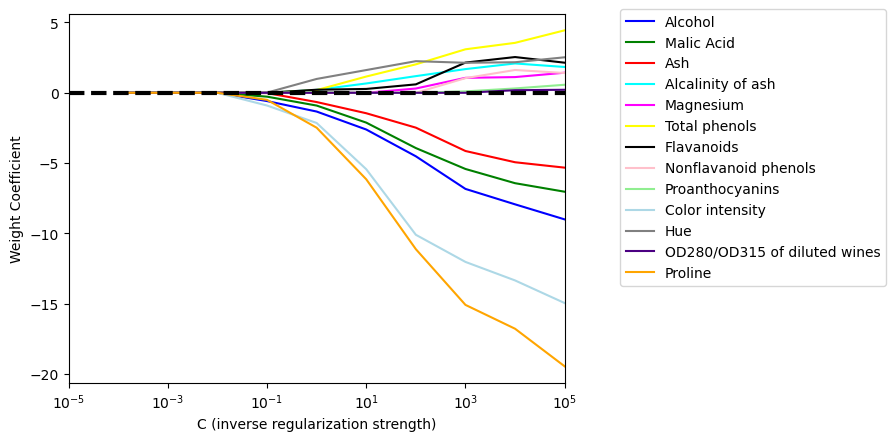

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 
          'green', 
          'red', 
          'cyan', 
          'magenta', 
          'yellow', 
          'black', 
          'pink', 
          'lightgreen', 
          'lightblue', 
          'gray', 
          'indigo',
          'orange']
weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', 
                            C=10.**c, 
                            solver='liblinear', 
                            multi_class='ovr', 
                            random_state=31415926)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, 
             weights[:, column], 
             label=df_wine.columns[column + 1], 
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Weight Coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03), 
          ncol=1, 
          fancybox=True)
plt.show();

## Sequential Backward Selection

- It aims to reduce the dimensionality of the initial feature subspace with minimum decay in the performance of the classifier to improve computational efficiency.
- SBS removes features sequentially from the full feature subset until the new feature subspace contains the desired number of features.
- Algorithm:
    - Initialize the algorithm with k = d, where d is the dimensionality of the full feature space, $X_d$
    - Determine the feature, $x\bar$ that maximizes the criterion: $x\bar = argmaxJ(X_k - x)$, where $x \epsilon X_k$
    - Remove the feature, $x\bar$ from the feature set: $X_{k-1} = X_k - x\bar; k = k - 1$
    - Terminate if k equals the number of desired features; otherwise go to step 2.

In [46]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS:
    def __init__(self, 
                 estimator, 
                 k_features, 
                 scoring=accuracy_score, 
                 test_size=0.25, 
                 random_state=31415926):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=self.test_size, 
                                                            random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

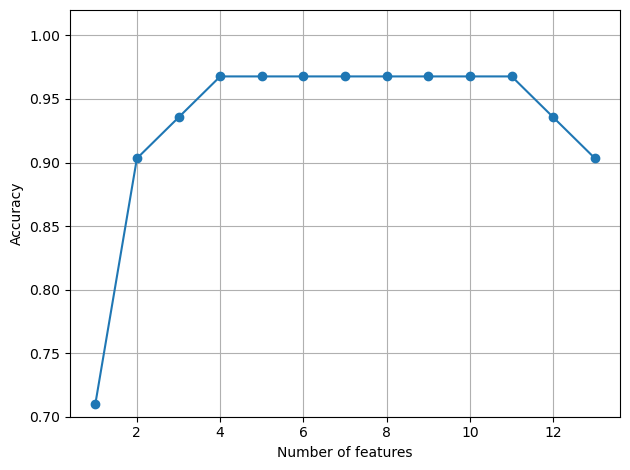

In [47]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show();

In [50]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 9, 12),
 (0, 1, 2, 3, 4, 6, 7, 9, 12),
 (0, 1, 2, 4, 6, 7, 9, 12),
 (0, 1, 2, 4, 6, 9, 12),
 (0, 1, 4, 6, 9, 12),
 (0, 4, 6, 9, 12),
 (0, 6, 9, 12),
 (0, 6, 9),
 (0, 6),
 (6,)]

In [51]:
# Check the smallest number of features
k4 = list(sbs.subsets_[9])
print(df_wine.columns[1:][k4])

Index(['Alcohol', 'Flavanoids', 'Color intensity', 'Proline'], dtype='object')


## Accessing Feature Importance with Random Forests

1) Proline: 0.17950060306350651
2) Color intensity: 0.1621141500697385
3) Flavanoids: 0.13694928461749906
4) OD280/OD315 of diluted wines: 0.12968383587268736
5) Alcohol: 0.12406367602103414
6) Hue: 0.0808037097999503
7) Total phenols: 0.04949235649450179
8) Malic Acid: 0.03250221252252126
9) Alcalinity of ash: 0.03230754572915321
10) Magnesium: 0.027243083864778955
11) Ash: 0.01640931566696129
12) Nonflavanoid phenols: 0.01471990827490767
13) Proanthocyanins: 0.014210318002759957


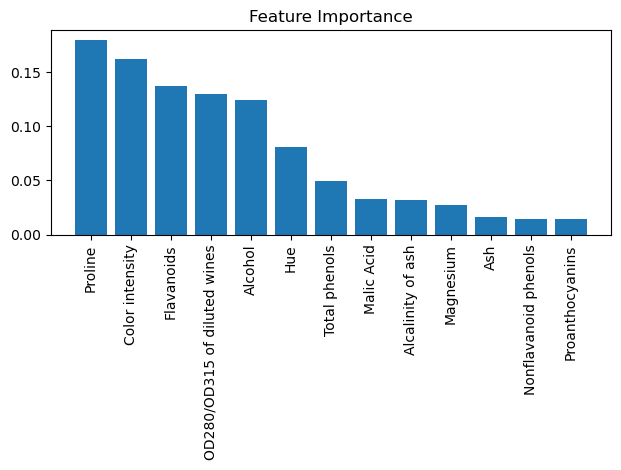

In [54]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500, random_state=31415926)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(f"{f+1}) {feat_labels[indices[f]]}: {importances[indices[f]]}")
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices], 
        align='center')
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], 
           rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show();